In [ ]:
''''COMPARE LARIAC, NEARMAP, AND ASSESSOR DATA AT LANDBASE'S AIN LVL

LANDBASE: 2016, PARCEL GEOM 
LARIAC: 2020, CALC. GROSS BLFG FOOTPRINT AREA (PER AIN, ALL STRUCTURES )
NEARMAP: 2023, CALC. GROSS BLFG FOOTPRINT AREA (PER AIN, ALL STRUCTURES )
ASSESSOR: 2016, SET AIN, SET SQFTMAIN (PER AIN, ALL STRUCTURES )

DIFF: LARIAC - ASSESSOR , BFP AREA - LVG AREA
DIFF: NEARMAP - ASSESSOR, BFP AREA - LVG AREA
'''

"'COMPARE LARIAC, NEARMAP, AND ASSESSOR DATA AT LANDBASE'S AIN LVL\n\nLANDBASE: 2016, SET PARCELS GEOM W/ AIN \nLARIAC: 2020, CALC. GROSS BLFG FOOTPRINT AREA (PER AIN, ALL STRUCTURES )\nNEARMAP: 2023, CALC. GROSS BLFG FOOTPRINT AREA (PER AIN, ALL STRUCTURES )\nASSESSOR: 2016, SET SQFTMAIN (PER AIN, ALL STRUCTURES )\n\nDIFF: LARIAC - ASSESSOR , BFP AREA - LVG AREA\nDIFF: NEARMAP - ASSESSOR, BFP AREA - LVG AREA\n"

In [ ]:
import geopandas as gpd

nearmap_building = '/Users/adamswietek/Downloads/USC_Nearmap_Sample_Data/AI_SAMPLE/ai_features_None_Building.gpkg'
nearmap_building = gpd.read_file(nearmap_building)


In [163]:
'''load data by year'''
from src.geoadmin import load_laraic, get_landbase_bymask, load_assessor_parcels_bygeom

LANDBASE_YR = 2016
ASSESSOR_YR = 2016
LARIAC_YR = 2020

def load_data_by_year(neighborhood, 
                      lb_yr, apd_yr, lar_yr, source = 'lariac'):
    
    landbase_parcels = get_landbase_bymask(neighborhood, lb_yr)

    polygon_geometry = neighborhood.to_crs(4326).iloc[0].geometry
    assessor_data = load_assessor_parcels_bygeom(polygon_geometry)
    assessor_data = assessor_data.loc[assessor_data.RollYear == apd_yr]
    assessor_data = assessor_data.to_crs(landbase_parcels.crs)

    if source == 'lariac':
        lariac_structures = load_laraic(neighborhood, lar_yr)
        lariac_structures = lariac_structures.to_crs(landbase_parcels.crs)

    return landbase_parcels, assessor_data, lariac_structures

landbase, assessor, lariac = load_data_by_year(nearmap_tile.dissolve(), 
                                               lb_yr = LANDBASE_YR, 
                                               apd_yr = ASSESSOR_YR, 
                                               lar_yr = LARIAC_YR)

landbase2, assessor2, lariac2 = load_data_by_year(nearmap_tile.dissolve(), 
                                               lb_yr = 2016, 
                                               apd_yr = 2020, 
                                               lar_yr = 2014)

ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
/opt/homebrew/Caskroom/miniforge/base/envs/samgeo/lib/python3.12/site-packages/pyogrio/core.py:280: UserWarning: Measured (M) geometry types are not supported. 

In [39]:
print(landbase.crs, assessor.crs, lariac.crs, nearmap_building.crs)

EPSG:2229 EPSG:2229 EPSG:2229 EPSG:2229


count    5321.000000
mean        1.385265
std         3.603433
min       -21.321177
25%        -0.712260
50%         1.085000
75%         3.354761
max        25.880972
dtype: float64


<Axes: >

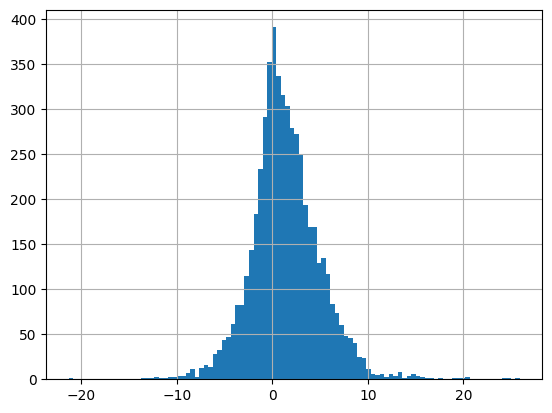

In [82]:
' calculated area vs area col is different. why?'
print((nearmap_building.area - nearmap_building.areaSqft).describe())#.hist(bins = 100)
(nearmap_building.area - nearmap_building.areaSqft).hist(bins = 100)

# (nearmap_building.area - nearmap_building.clippedAreaSqft).hist(bins = 100)

count    6.107000e+03
mean    -7.834790e-09
std      4.385217e-07
min     -2.692366e-06
25%     -2.472867e-07
50%     -1.251772e-08
75%      2.229658e-07
max      3.229070e-06
dtype: float64


<Axes: >

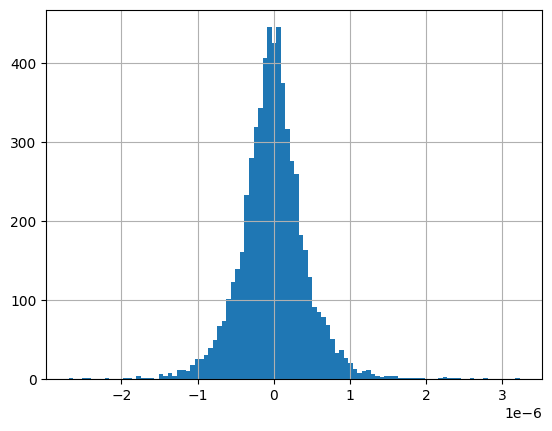

In [ ]:
''' difference betwen lariac area col and calculated area is much smaller than nearmap's?'''
print((lariac.AREA - lariac.area).describe())
(lariac.AREA - lariac.area).hist(bins = 100)


In [103]:
nearmap_building['geomarea'] = nearmap_building.area
nm = nearmap_building[['id','areaSqft','clippedAreaSqft','geomarea','geometry']].copy()

lb = landbase[['ASSETID', 'geometry']].copy()

asr = assessor.copy()

lar = lariac.dropna(subset=['HEIGHT'])[['BLD_ID','AREA', 'geometry']].copy()

In [104]:
print(lb.shape, asr.shape, lar.shape, nm.shape)

(4303, 2) (3449, 52) (6090, 3) (5321, 5)


In [ ]:
'''merge landbase and assessor'''
joined = gpd.sjoin(lb, asr, how='inner', predicate='intersects')

''' add lariac data to joined, sum area by AIN'''
joined_lar = gpd.sjoin(joined.drop(columns=['index_right']), lar, how='left', predicate='intersects')
''' add nearmaps data to joined, sum area by AIN'''
joined_nm = gpd.sjoin(joined.drop(columns=['index_right']), nm, how='left', predicate='intersects')


In [ ]:
'''merge landbase and assessor'''
joined2 = gpd.sjoin(lb, assessor2, how='inner', predicate='intersects')
joined2.groupby('AIN')['SQFTMAIN'].sum().describe()

count    3407.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

In [168]:
results = {
    'size': joined.groupby('AIN').size(),
    'lariac_area_2020': joined_lar.groupby('AIN')['AREA'].sum(),
    'nearmap_area_2023': joined_nm.groupby('AIN')['areaSqft'].sum(),
    'assessor_area_2016': joined.groupby('AIN')['SQFTmain'].sum(),
    'assessor_area_2020': joined2.groupby('AIN')['SQFTmain'].sum(),
    #add geoms
    'lariac_geom_2020': joined_lar.groupby('AIN')['geometry'].apply(lambda x: x.unary_union),
    'nearmap_geom_2023': joined_nm.groupby('AIN')['geometry'].apply(lambda x: x.unary_union),
    'landbase_geom_2016': joined.groupby('AIN')['geometry'].apply(lambda x: x.unary_union)
}

/var/folders/7b/rl6lkdns1dbfv_n3wwwmq8580000gn/T/ipykernel_43763/1573776489.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  'lariac_geom_2020': joined_lar.groupby('AIN')['geometry'].apply(lambda x: x.unary_union),
/var/folders/7b/rl6lkdns1dbfv_n3wwwmq8580000gn/T/ipykernel_43763/1573776489.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  'nearmap_geom_2023': joined_nm.groupby('AIN')['geometry'].apply(lambda x: x.unary_union),
/var/folders/7b/rl6lkdns1dbfv_n3wwwmq8580000gn/T/ipykernel_43763/1573776489.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  'landbase_geom_2016': joined.groupby('AIN')['geometry'].apply(lambda x: x.unary_union)


In [169]:
import geopandas as gpd

df = gpd.GeoDataFrame(results, geometry='landbase_geom_2016')

In [170]:
'''--- SUMMARY STATS ---'''
area_cols = ['lariac_area_2020', 'nearmap_area_2023', 'assessor_area_2016', 'assessor_area_2020']

print(f"df shape: {df.shape}")
print(f"\nZero / NaN counts:")
for c in area_cols:
    print(f"  {c:25s}  zero={int((df[c] == 0).sum()):4d}   NaN={int(df[c].isna().sum()):4d}")

print("\n--- Area distributions (sqft) ---")
df[area_cols].describe().round(1)

df shape: (3461, 8)

Zero / NaN counts:
  lariac_area_2020           zero= 102   NaN=  13
  nearmap_area_2023          zero=  63   NaN=  13
  assessor_area_2016         zero= 236   NaN=  13
  assessor_area_2020         zero= 135   NaN=  54

--- Area distributions (sqft) ---


,lariac_area_2020,nearmap_area_2023,assessor_area_2016,assessor_area_2020
count,3448.0,3448.0,3448.0,3407.0
mean,3564.4,7547.6,2572.0,2683.2
std,3644.9,5926.3,4344.0,5536.9
min,0.0,0.0,0.0,0.0
25%,2155.1,4629.8,1248.0,1279.5
50%,2671.5,6018.0,1732.0,1758.0
75%,3396.6,8445.0,2536.8,2618.5
max,59085.1,63282.0,82689.0,173222.0


In [173]:
'''filter to parcels with positive area in all four sources for clean comparisons'''
import numpy as np

mask = (
    (df['lariac_area_2020'] > 0) & 
    (df['nearmap_area_2023'] > 0) & 
    (df['assessor_area_2016'] > 0) & 
    (df['assessor_area_2020'] > 0)
)
dfc = df[mask].copy()
print(f"Parcels with all 4 areas > 0: {len(dfc)} / {len(df)}")

# absolute differences
dfc['diff_lar20_asr16'] = dfc['lariac_area_2020'] - dfc['assessor_area_2016']
dfc['diff_lar20_asr20'] = dfc['lariac_area_2020'] - dfc['assessor_area_2020']
dfc['diff_nm23_asr16']  = dfc['nearmap_area_2023'] - dfc['assessor_area_2016']
dfc['diff_nm23_asr20']  = dfc['nearmap_area_2023'] - dfc['assessor_area_2020']
dfc['diff_nm23_lar20']  = dfc['nearmap_area_2023'] - dfc['lariac_area_2020']
dfc['diff_asr20_asr16'] = dfc['assessor_area_2020'] - dfc['assessor_area_2016']

# percentage differences
dfc['pct_diff_lar20_asr16'] = (dfc['diff_lar20_asr16'] / dfc['assessor_area_2016']) * 100
dfc['pct_diff_lar20_asr20'] = (dfc['diff_lar20_asr20'] / dfc['assessor_area_2020']) * 100
dfc['pct_diff_nm23_asr16']  = (dfc['diff_nm23_asr16']  / dfc['assessor_area_2016']) * 100
dfc['pct_diff_nm23_asr20']  = (dfc['diff_nm23_asr20']  / dfc['assessor_area_2020']) * 100
dfc['pct_diff_nm23_lar20']  = (dfc['diff_nm23_lar20']  / dfc['lariac_area_2020']) * 100
dfc['pct_diff_asr20_asr16'] = (dfc['diff_asr20_asr16'] / dfc['assessor_area_2016']) * 100

print("\n--- Absolute Differences (sqft) ---")
diff_cols = ['diff_lar20_asr16', 'diff_lar20_asr20', 'diff_nm23_asr16', 
             'diff_nm23_asr20', 'diff_nm23_lar20', 'diff_asr20_asr16']
print(dfc[diff_cols].describe().round(1))

print("\n--- Percentage Differences (%) ---")
pct_cols = ['pct_diff_lar20_asr16', 'pct_diff_lar20_asr20', 'pct_diff_nm23_asr16',
            'pct_diff_nm23_asr20', 'pct_diff_nm23_lar20', 'pct_diff_asr20_asr16']
print(dfc[pct_cols].describe().round(1))

Parcels with all 4 areas > 0: 3166 / 3461

--- Absolute Differences (sqft) ---
       diff_lar20_asr16  diff_lar20_asr20  diff_nm23_asr16  diff_nm23_asr20  \
count            3166.0            3166.0           3166.0           3166.0   
mean              567.7             535.1           4605.2           4572.6   
std              3085.1            3085.9           5299.0           5298.7   
min            -64761.6          -64761.6         -59304.0         -59304.0   
25%               184.9             114.1           2565.8           2516.8   
50%               778.6             746.0           3923.5           3895.5   
75%              1251.6            1226.4           5827.5           5811.5   
max             32982.7           32982.7          53097.0          53097.0   

       diff_nm23_lar20  diff_asr20_asr16  
count           3166.0            3166.0  
mean            4037.5              32.6  
std             4264.3             279.5  
min           -13651.8           -146

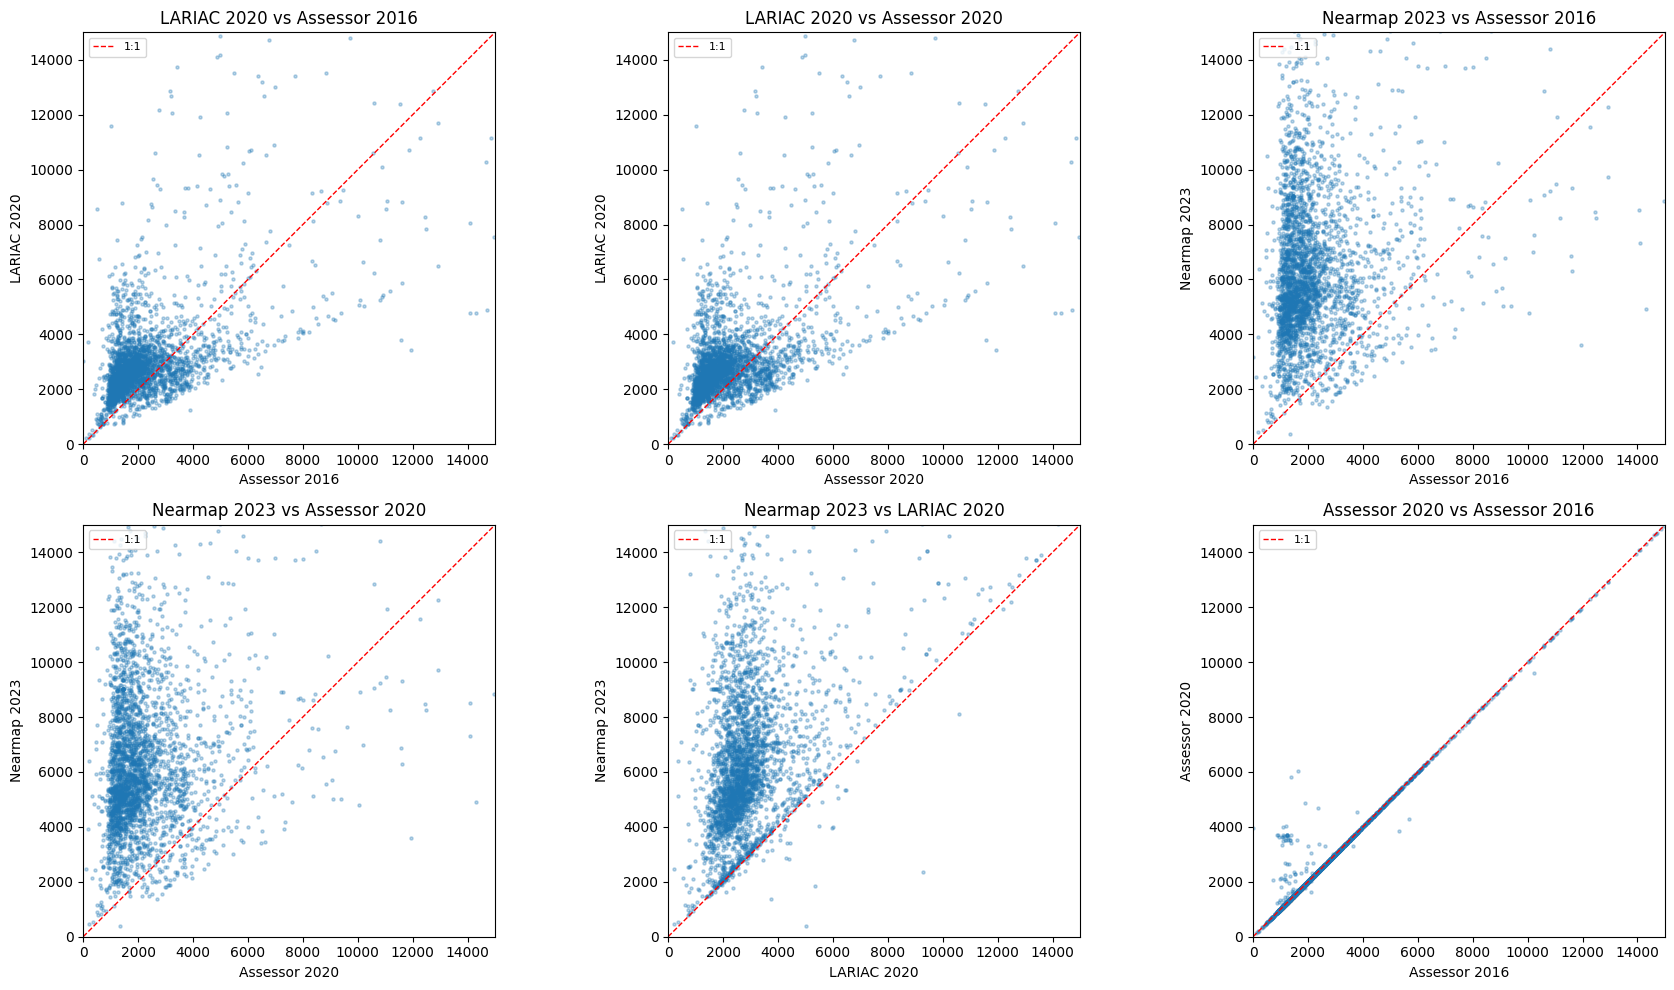

In [174]:
'''--- SCATTER PLOTS: pairwise area comparisons ---'''
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

pairs = [
    ('assessor_area_2016', 'lariac_area_2020',  'Assessor 2016', 'LARIAC 2020'),
    ('assessor_area_2020', 'lariac_area_2020',  'Assessor 2020', 'LARIAC 2020'),
    ('assessor_area_2016', 'nearmap_area_2023', 'Assessor 2016', 'Nearmap 2023'),
    ('assessor_area_2020', 'nearmap_area_2023', 'Assessor 2020', 'Nearmap 2023'),
    ('lariac_area_2020',   'nearmap_area_2023', 'LARIAC 2020',   'Nearmap 2023'),
    ('assessor_area_2016', 'assessor_area_2020','Assessor 2016', 'Assessor 2020'),
]

for ax, (xcol, ycol, xlab, ylab) in zip(axes.flat, pairs):
    ax.scatter(dfc[xcol], dfc[ycol], alpha=0.3, s=5)
    ax.plot([0, 15000], [0, 15000], 'r--', lw=1, label='1:1')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(f'{ylab} vs {xlab}')
    ax.set_aspect('equal')
    ax.set_xlim(0, 15000)
    ax.set_ylim(0, 15000)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

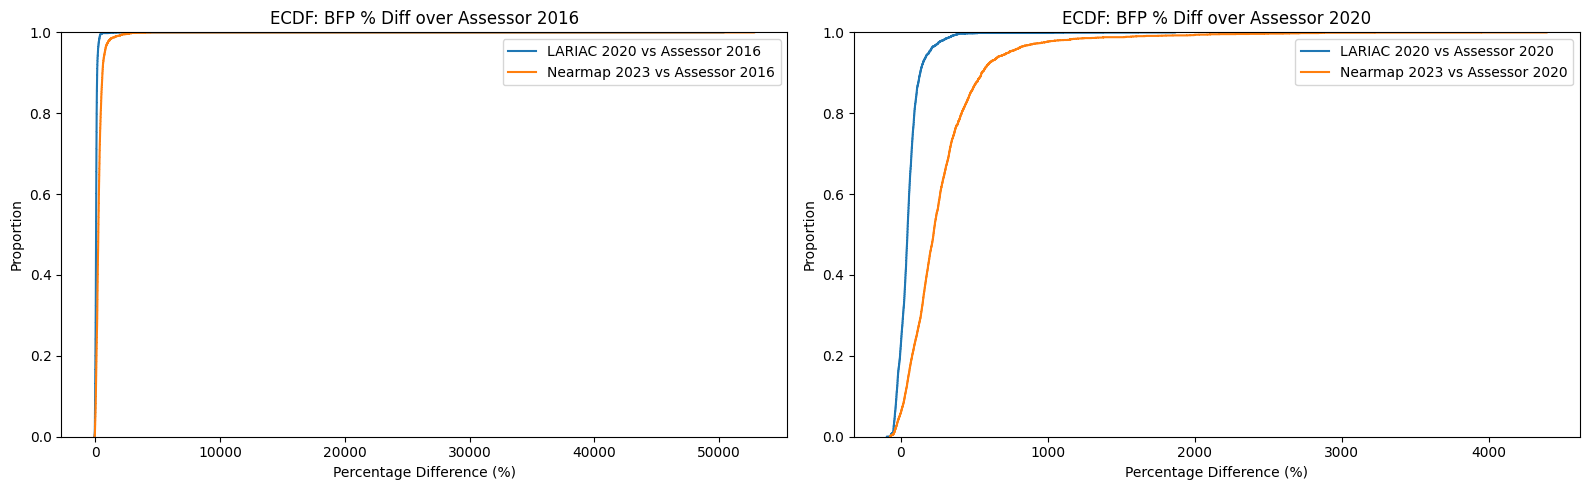

In [175]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ECDF of pct diff vs Assessor 2016
ax = axes[0]
sns.ecdfplot(dfc['pct_diff_lar20_asr16'], label='LARIAC 2020 vs Assessor 2016', ax=ax)
sns.ecdfplot(dfc['pct_diff_nm23_asr16'],  label='Nearmap 2023 vs Assessor 2016', ax=ax)
ax.set_xlabel('Percentage Difference (%)')
ax.set_title('ECDF: BFP % Diff over Assessor 2016')
ax.legend()

# ECDF of pct diff vs Assessor 2020
ax = axes[1]
sns.ecdfplot(dfc['pct_diff_lar20_asr20'], label='LARIAC 2020 vs Assessor 2020', ax=ax)
sns.ecdfplot(dfc['pct_diff_nm23_asr20'],  label='Nearmap 2023 vs Assessor 2020', ax=ax)
ax.set_xlabel('Percentage Difference (%)')
ax.set_title('ECDF: BFP % Diff over Assessor 2020')
ax.legend()

plt.tight_layout()
plt.show()

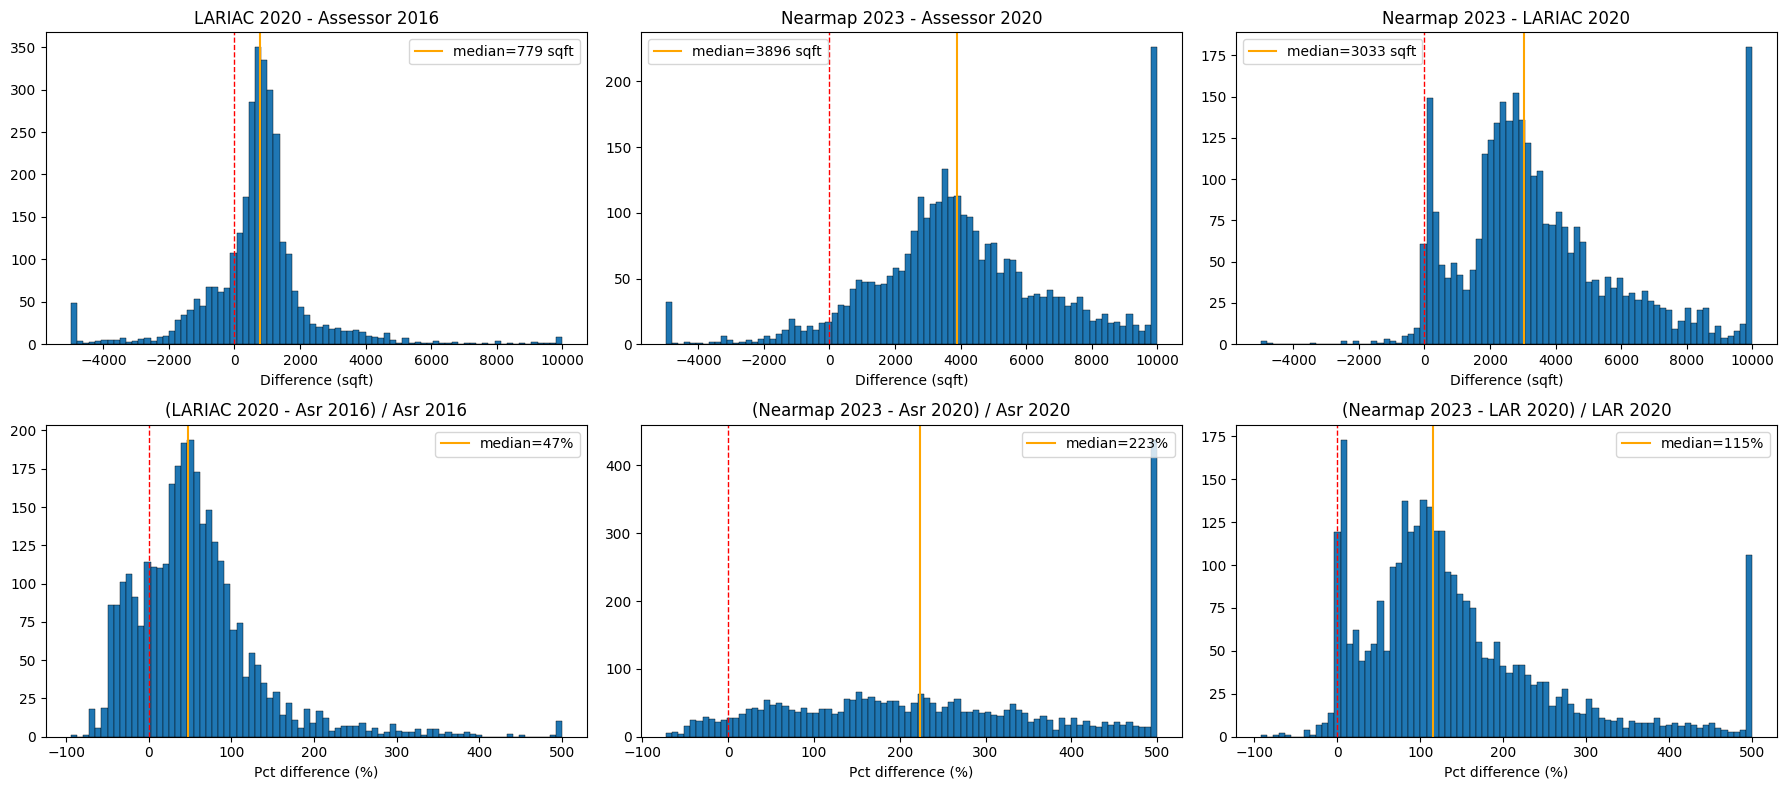

In [176]:
'''--- HISTOGRAMS: difference & pct difference distributions ---'''
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Row 1: absolute differences
diff_pairs = [
    ('diff_lar20_asr16', 'LARIAC 2020 - Assessor 2016'),
    ('diff_nm23_asr20',  'Nearmap 2023 - Assessor 2020'),
    ('diff_nm23_lar20',  'Nearmap 2023 - LARIAC 2020'),
]
for ax, (col, title) in zip(axes[0], diff_pairs):
    vals = dfc[col].clip(-5000, 10000)
    ax.hist(vals, bins=80, edgecolor='black', linewidth=0.3)
    ax.axvline(0, color='red', linestyle='--', lw=1)
    ax.axvline(dfc[col].median(), color='orange', lw=1.5, 
               label=f'median={dfc[col].median():.0f} sqft')
    ax.set_title(title)
    ax.set_xlabel('Difference (sqft)')
    ax.legend()

# Row 2: percentage differences
pct_pairs = [
    ('pct_diff_lar20_asr16', '(LARIAC 2020 - Asr 2016) / Asr 2016'),
    ('pct_diff_nm23_asr20',  '(Nearmap 2023 - Asr 2020) / Asr 2020'),
    ('pct_diff_nm23_lar20',  '(Nearmap 2023 - LAR 2020) / LAR 2020'),
]
for ax, (col, title) in zip(axes[1], pct_pairs):
    vals = dfc[col].clip(-200, 500)
    ax.hist(vals, bins=80, edgecolor='black', linewidth=0.3)
    ax.axvline(0, color='red', linestyle='--', lw=1)
    ax.axvline(dfc[col].median(), color='orange', lw=1.5,
               label=f'median={dfc[col].median():.0f}%')
    ax.set_title(title)
    ax.set_xlabel('Pct difference (%)')
    ax.legend()

plt.tight_layout()
plt.show()